# LangGraph Agent in Memory
Defining the agent's graph (state, nodes, edges) and run it in memory.

## Env & Variables
Running package install and defining global variables from separate Notebooks.

In [0]:
%run ./step0_Environment

# Environment Set up
Installing packages and configuring environment.

## Packages Install

Python 3.12.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.20.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.19.5, but you have protobuf 6.33.5 which is incompatible.
grpcio-status 1.67.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.5 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-health-checking 1.76.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.6 which is incompatible.
grpcio-tools 1.75.1 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.6 which is incompatible.
langgraph-a

## Configure Logging

In [0]:
%run ./step0_Variables

# Global Variables definition
Creating global variables.

In [0]:
%run ./step2_Prompts_Definition

# Prompts Definition
Defining all prompts for the nodes and tools used by the agent.

## Assistant Prompt
Prompt used by the Assistant (the "reasoning" node we'll define in the ReAct agent architecture).

## Classification Prompt
Prompt used by the classification tool.

## Schemas
Defining the desired agent's State and output schemas.

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Output Schema
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from pydantic import BaseModel, Field
from typing import Literal

class FinalOutput(BaseModel):
  Customer_Email: str = Field(description = "Email of the customer who sent the message.")
  Customer_Id: str = Field(description = "Id of the customer, related to the email. If not found, return NULL.")
  Customer_Context: str = Field(description = "Summary of all the retrieved information related to the customer's request. If nothing was retrieved, return NULL.")
  Label: Literal[
      "Order Issues",
      "Returns & Refunds",
      "Claims & Complaints",
      "Account & Data Requests",
      "Product Information",
      "Payment & Billing",
      "Spam",
      "Others",
      "Classification Error"] = Field(
    description="Generated label assigned to the email",
    default="Classification Error")
  Rationale: str = Field(description="Reasoning behind the label choice")
  Next_steps: str = Field(description="Recommended action items based on the customer's email")


In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Graph State
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages, AnyMessage
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

## Set up the agent state to concatenate messages in memory
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    final_output: FinalOutput | None

## LLMs
Defining the base LLM to be used by the agent nodes.

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Base LLM
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from databricks_langchain import ChatDatabricks
model = ChatDatabricks(endpoint = llm_endpoint, temperature=0) 

PyTorch was not found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Unexpected internal error when monkey patching `PreTrainedModel.from_pretrained`: 
PreTrainedModel requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.

Unexpected internal error when monkey patching `Trainer.train`: 
Trainer requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.



In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Respond Model (LLM + Output schema)
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
model_with_output_schema = model.with_structured_output(FinalOutput)

## Tools
Specify all tools the agent can use to retrieve information and classify emails.

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Classification Tool
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from langchain_core.tools import tool
from langgraph.graph import MessagesState

@tool
def classify_email(customer_info: str, order_info: str, ticket_info: str,  email_body: str) -> str:
    """ Classify the customer's email into one of the predefined labels, based on the email_body and the available context you could retrieve:\n
    * customer_info - representing the customer's details in our database\n
    * order_info - representing the latest customer's order\n
    * ticket_info - representing the latest customer's ticket\n
    """
    
    # Promopt template
    MODEL_SYSTEM_MESSAGE = Classification_Prompt

    # Pass data to the prompt
    full_prompt = MODEL_SYSTEM_MESSAGE.format(
        email_body=email_body,
        customer_info=customer_info,
        order_info=order_info,
        ticket_info=ticket_info
    )

    # Invoke LLM & return
    result = model.invoke([full_prompt])
    return result.content

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# UC functions as Retrieval Tools
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from databricks_langchain import UCFunctionToolkit

toolkit = UCFunctionToolkit(function_names=[
      f"{catalog_}.{schema_}.classificator_agent_customer_retriever",
      f"{catalog_}.{schema_}.classificator_agent_order_retriever",
      f"{catalog_}.{schema_}.classificator_agent_ticket_retriever",
])
uc_tools = toolkit.tools

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b3d430f9-8d9a-405d-8e2b-54c5cd2f5085/lib/python3.12/site-packages/databricks/connect/session.py:476: UserWarning: Ignoring the default notebook Spark session and creating a new Spark Connect session. To use the default notebook Spark session, use DatabricksSession.builder.getOrCreate() with no additional parameters.
  warnings.warn(new_notebook_session_msg)


In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Create Tool Binding
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

tools = uc_tools + [classify_email] ## Combine all tools above (uc + custom)
model_with_tools = model.bind_tools(tools)

## Nodes
Creating the reasoning node (assistant) and the respond node.

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Reasoning Node (Assistant)
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content=Assistant_Prompt)

# Reasoning Node
def assistant(state: AgentState) -> AgentState:
  result = model_with_tools.invoke([sys_msg] + state["messages"])
  return {"messages": state["messages"] + [result]}

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Respond Node: Enforce output schema on the final answer
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

def respond(state: AgentState) -> AgentState:
    # Uses the last message as input to the structured output model
    last_msg = state["messages"][-1]
    result = model_with_output_schema.invoke(
        [HumanMessage(content=last_msg.content)]
    )
    return {"final_output": result}

## Graph

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# ReAct Graph
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Add Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("respond", respond)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {"tools": "tools", "__end__": "respond"} # customize mapping which would route to end by default
)
builder.add_edge("tools", "assistant") # ReAct: return tool outputs to reason on it!
builder.add_edge("respond", END)
react_email_classifier = builder.compile() # No checkpointer (memory) needed

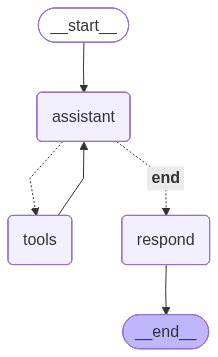

In [0]:
# Display the Graph
display(Image(react_email_classifier.get_graph().draw_mermaid_png()))

## Testing
Run a test case with Notebook context

In [0]:
## Save test cases
spark.sql("USE CATALOG "+catalog_)
spark.sql("USE SCHEMA "+schema_)
df_test_emails = spark.table("classificator_agent_emails")

In [0]:
from pyspark.sql.functions import *

# Extract test case from the dataframe with examples
id_ = 7
test_record = df_test_emails.filter(col("Email_Id") == id_).first()
message_ = f"We received from: {test_record.Email_Sender} the following email: {test_record.Email_Body}"
display(message_)

'We received from: sofia.rossi@example.com the following email: Understood, thank you.'

In [0]:
from pyspark.sql.functions import *
from langchain_core.messages import HumanMessage
import mlflow

# Invoke the Agent
config_ = {"configurable": {"thread_id": id_}} # Not required if we're not using memory

mlflow.langchain.autolog()
with mlflow.start_run(run_name="React Email Classifier Agent - Test"):
  request = [
    HumanMessage(content = message_)
  ]
  messages = react_email_classifier.invoke({"messages": request}, config_)

  for m in messages['messages']:
      m.pretty_print()

================================ Human Message =================================

We received from: sofia.rossi@example.com the following email: Understood, thank you.
================================== Ai Message ==================================

I need to retrieve the relevant context information for this customer before classifying the email. Let me look up the customer details, their latest order, and any recent tickets.
Tool Calls:
  users__gabriele_albini__classificator_agent_customer_retriever (toolu_bdrk_01Qc92HR1sDt78WVbzBWT1VP)
 Call ID: toolu_bdrk_01Qc92HR1sDt78WVbzBWT1VP
  Args:
    customer_email: sofia.rossi@example.com
================================= Tool Message =================================
Name: users__gabriele_albini__classificator_agent_customer_retriever

{"format": "SCALAR", "value": "Row(Customer_Id=3, Name='Sofia', Surname='Rossi', Email='sofia.rossi@example.com', Address='Via Milano 11, 20126 Milano, Italy')"}
================================== Ai Messa

Trace(trace_id=tr-501435881cbc4f2e66dbc82582da9660)

In [0]:
%sql
-- Available Context: Customer Details
SELECT classificator_agent_customer_retriever('sofia.rossi@example.com') AS customer_details;

customer_details
"List(3, Sofia, Rossi, sofia.rossi@example.com, Via Milano 11, 20126 Milano, Italy)"


In [0]:
%sql
-- Available Context: Order Details
SELECT classificator_agent_order_retriever(3) AS order_details;

order_details
"List(ID-45892183, 2025-11-11, [""Mouse Pad"", ""Ergonomic Wrist Rest""], 42.3, 3)"


In [0]:
%sql
-- Available Context: Ticket Details
SELECT classificator_agent_ticket_retriever(3) AS ticket_details;

ticket_details
"List(3, TKT-004, 2025-11-28 10:48:57, Dear team, I returned an item last week but haven’t received my refund confirmation yet. When should I expect it?, Returns & Refunds)"
